In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:80% !important; } </style?"))
import icepython as ice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.dates as mdates
from enum import Enum
import os

In [2]:
################################################
####### Varables that can be changed ###########
model_name           = 'GEFS'  #  GEFS or ECE
location             = 'GWUS'  # There are 100 stations and over 80+ regions
num_of_days_back     = 90
################################################
################################################

model_run            = '00Z'
model_run_and_name   = model_run + '-' + model_name
now                  = datetime.now()
model_run_start_date = now
model_run_end_date   = now 
start_date_history   = (now - timedelta(days=num_of_days_back)).strftime('%Y-%m-%d')
end_date_history     = (now - timedelta(days=1)).strftime('%Y-%m-%d')

In [3]:
class MODEL_NAME(Enum):
    ECE    = 'ECE'
    GEFS   = 'GEFS'
 
MODEL_SPECS  = {
    MODEL_NAME.ECE.value:{
        "num_of_fcst_days" : 15
     },
    MODEL_NAME.GEFS.value:{
        "num_of_fcst_days" : 16
     }
}

num_of_fcst_days = MODEL_SPECS[model_name]['num_of_fcst_days']

In [4]:
def get_data(symbol, field, start_date, end_date):
    data    = ice.get_timeseries(symbol, field, granularity = 'D', start_date= start_date, end_date  = end_date)   
   
    return data

def get_climo():
    field               = 'GWDD official 30yr Climo'
    start_date_climo    = (datetime(2022, 1, 1)).strftime('%Y-%m-%d')
    end_date_climo      = (datetime(2022, 12, 31)).strftime('%Y-%m-%d')
    symbol              = location + '-CLMO'
    climo               = get_data([symbol], field, start_date_climo, end_date_climo)

    return climo

def get_history(climo_type, start_date_history, end_date_history):
    field         = 'GWDD'
    symbol        = [location + '-' + climo_type]
    history       = get_data(symbol, field, start_date_history, end_date_history)
    
    return history

def get_fcst(model_run_start_date, model_run_end_date):
    fcst_series1=[]; fcst_series2=[];fcst_series3=[];fcst_series4=[];fcst_series5=[]
    for model_run_date in np.arange(model_run_start_date, model_run_end_date, timedelta(days=1)).astype(datetime):
        model_run_date_str        = model_run_date.strftime('%y%m%d')
        symbol                    = location + ' MR' + model_run_date_str + '_' + model_run_and_name
        start_date                = model_run_date.strftime('%Y-%m-%d')
        end_date                  = (model_run_date + timedelta(days=num_of_fcst_days)).strftime('%Y-%m-%d')
      
        field       = ['GWDD',  'GWDD CHNG 1 Forecast Prior', 'GWDD CHNG 2 Forecast Prior', 'GWDD CHNG 4 Forecast Prior','GWDD official 30yr Anomaly']
        fcst                      = get_data(symbol, field, start_date, end_date)
        df_data                   = pd.DataFrame(list(fcst))
        df_data                   = df_data.iloc[1:] 
        df_data                   = df_data.iloc[:,1:]
    
        fcst_total                = round(df_data,1)
    
        fcst_series1               = np.append(fcst_series1, fcst_total[1])
        fcst_series2               = np.append(fcst_series2, fcst_total[2])
        fcst_series3               = np.append(fcst_series3, fcst_total[3])
        fcst_series4               = np.append(fcst_series4, fcst_total[4])
        fcst_series5               = np.append(fcst_series5, fcst_total[5])
        
    return fcst_series1, fcst_series2, fcst_series3, fcst_series4, fcst_series5

def get_df(data, data_name):
    df                 = pd.DataFrame(list(data))
    df_history         = df.iloc[1:]
    df_history         = df_history.rename(columns={0:'Date', 1:'GWDD'})
    df_history['Date'] = pd.DatetimeIndex(df_history['Date'])
    df_history['GWDD'] = pd.to_numeric(df_history['GWDD'])
    df_history         = df_history.set_index(['Date'])
    df_history         = df_history.drop(df_history[(df_history.index.month == 2) & (df_history.index.day == 29)].index)
    
    return df_history

def get_df_fcst(fcst1, fcst2, fcst3, fcst4, fcst5, index):
    df_data             = pd.DataFrame({'GWDD':fcst1,'Change_1':fcst2,'Change_2':fcst3,'Change_4':fcst4,'Anomaly':fcst5, 'Date':index})
    date_rng            = pd.DatetimeIndex(df_data['Date']) 
    df_data['Month']    = date_rng.month.values
    df_data['Day']      = date_rng.day.values
    
    return df_data


def get_df_anomaly(df_history, df_climo):
    df_merge            = pd.merge(df_history, df_climo, on=['Month', 'Day'], how='inner') # or outer for the entire year
    df_merge            = df_merge[['Date_x', 'History', 'Climo']]
    df_merge            = df_merge.rename(columns={'Date_x':'Date'})

    df_merge['Anomaly'] = df_merge['History'] - df_merge['Climo']
    df_merge            = df_merge.sort_values(by='Date')

    df_anomaly          = df_merge[['Date', 'Anomaly']]
    df_anomaly          = df_anomaly.set_index('Date')
    df_anomaly.index    = pd.to_datetime(df_anomaly.index).date

    return df_anomaly
    
def merge_CFSR_and_METAR(df_history_METAR, df_history_CFSR):
    df_merge                            = pd.merge(df_history_METAR, df_history_CFSR,  how='outer', left_index=True, right_index=True)
    df_merge['GWDD_y']                  = df_merge['GWDD_y'].fillna(df_merge['GWDD_x'])
    df_merged_CFSR_and_METAR            = df_merge.drop('GWDD_x', axis=1)
    df_merged_CFSR_and_METAR            = df_merged_CFSR_and_METAR.rename(columns={'GWDD_y':'GWDD'})
    date_rng                            = df_merged_CFSR_and_METAR.index
    df_merged_CFSR_and_METAR['Date']    = date_rng
    df_merged_CFSR_and_METAR['Month']   = date_rng.month.values
    df_merged_CFSR_and_METAR['Day']     = date_rng.day.values
    df_merged_CFSR_and_METAR            = df_merged_CFSR_and_METAR.rename(columns={'GWDD':'History'})
    
    return df_merged_CFSR_and_METAR

def plot_time_series(df_history_and_fcst_anomaly):
    fig, ax1    = plt.subplots(1,1, figsize=(16,9), dpi=100)
    vertical_line = df_history_and_fcst_anomaly.index[df_history_and_fcst_anomaly.index==model_run_start_date.date()]

    tseries     = df_history_and_fcst_anomaly['Anomaly']
    color       = (tseries > 0).apply(lambda x: 'green' if x else 'brown')
    ax1.bar(df_history_and_fcst_anomaly.index, df_history_and_fcst_anomaly['Anomaly'], color=color, label = 'GWDD Anomaly')

    ax1.set_ylabel('GWDD Anomaly',fontsize=18)
    ax1.set_ylim(-20, 20)
    ax1.set_yticks(np.linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax1.get_yticks())))
    ax1.axhline(0, color='grey', linewidth=0.8)

    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))
    plt.gcf().autofmt_xdate(rotation=45)

    ax1.legend()
    ax1.set_title('Daily ' + location + ' GWDD Anomalies (Relative to the 30-yr Normal)\n'
            + 'Constructed from: Observations and ' + model_run_and_name + ' Forecast\n'
            + 'Model Run Date: ' + now.strftime('%a, %b %d'), fontsize=18)
    ax1.grid()

    ax1.axvline(vertical_line[0]-timedelta(hours=12),color='black', linewidth=2)
    plt.tight_layout()
    plt.show()

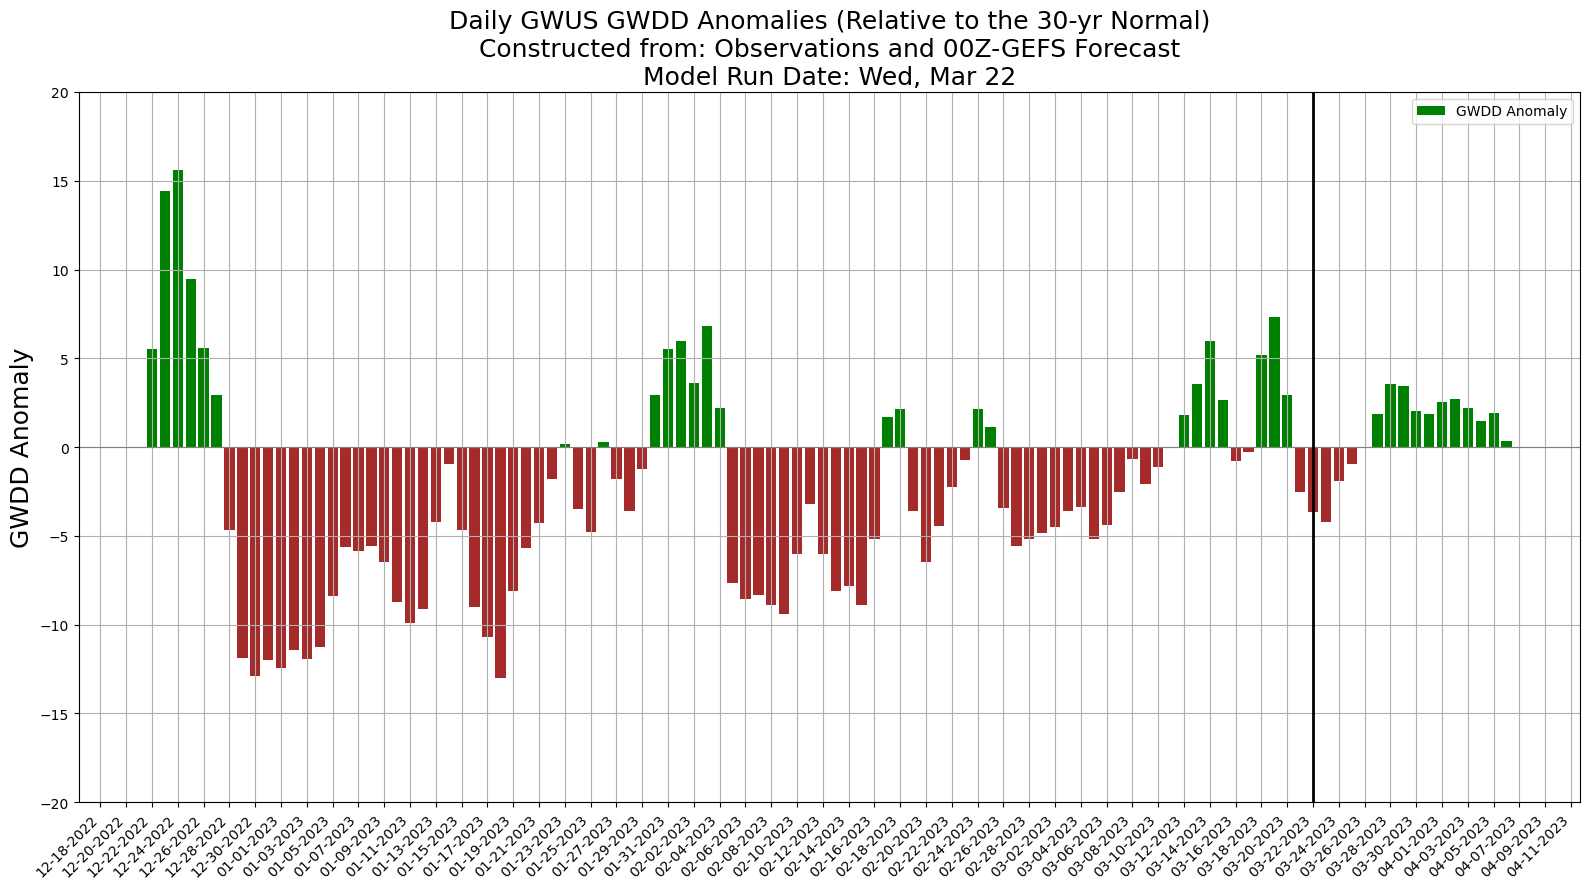

In [5]:
climo                              = get_climo()
history_CFSR                       = get_history('CFSR', start_date_history, end_date_history)
history_METAR                      = get_history('METR', start_date_history, end_date_history)

df_history_CFSR                    = get_df(history_CFSR, 'History')
df_history_METAR                   = get_df(history_METAR, 'History')
df_merged_CFSR_and_METAR           = merge_CFSR_and_METAR(df_history_METAR, df_history_CFSR)

df_climo                           = get_df(climo,   'Climo')
date_rng                           = df_climo.index
df_climo['Date']                   = date_rng
df_climo['Month']                  = date_rng.month.values
df_climo['Day']                    = date_rng.day.values
df_climo                           = df_climo.rename(columns={'GWDD':'Climo'})

df_history_anomaly                 = get_df_anomaly(df_merged_CFSR_and_METAR, df_climo)
index_fcst_days                    = np.arange(model_run_start_date, model_run_end_date +  timedelta(days=num_of_fcst_days), timedelta(days=1)).astype(datetime)
fcst1, fcst2, fcst3, fcst4, fcst5  = get_fcst(model_run_start_date, model_run_end_date + timedelta(days=1))
df_fcst                            = get_df_fcst(fcst1, fcst2, fcst3, fcst4, fcst5, index_fcst_days)
df_fcst                            = df_fcst.set_index('Date')
df_fcst.index                      = pd.to_datetime(df_fcst.index).date
df_fcst                            = df_fcst[['GWDD', 'Anomaly', 'Change_1', 'Change_2', 'Change_4']]

df_fcst_anomaly                    = df_fcst[['Anomaly']]

df_history_and_fcst_anomaly        =  df_history_anomaly.append(df_fcst_anomaly, ignore_index=False)
df_history_and_fcst_anomaly.tail()

plot_time_series(df_history_and_fcst_anomaly)